# Group No 97

## Group Member Names:
|No.|Member|Student ID|
|--|--|--|
|1|Shreysi Kalra|2021fc04586|
|2|Vinayak Nayak|2021fc04135|
|3|Ajith Praveen R|2021fc04329|

 **Problem Statement** 
 
Generate Image Captions using CNN+LSTM. (you can use pretrained models) 

Dataset: MNIST is a dataset of images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Requirements:

- tensorflow
- keras
- numpy, pandas, matplotlib
- Pillow, opencv, tqdm
- nltk (For evaluation of test set using BLEU Score)

All our code, data and other related information could be accessed on this [drive link](https://drive.google.com/drive/folders/186IWnzNgUQZNIvXYJSJPQDzz7JFUJAtT?usp=sharing).

# Import Libraries/Dataset/Prepare Data

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import all the needed libraries here
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

# Basic Libraries
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from pathlib import Path

# Image Image manipulation libraries
import PIL.Image

# Deep Learning Libraries
import tensorflow as tf
import keras
from keras.applications.resnet import ResNet50, preprocess_input
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, Dense, Flatten, BatchNormalization, 
                                     Reshape, Concatenate, Dropout, Input, add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# For evaluation
from nltk.translate.bleu_score import sentence_bleu

# For plotting
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Define constants here
START = "startseq"
STOP = "endseq"
EPOCHS = 12
BATCH_SIZE = 32
TEXT_EMBED_DIMENSION = 32
IMAGE_EMBED_DIMENSION = 2048

- Download the MNIST data
- Download a pretrained model (pretrained for ImageNet classification)
- Extract embeddings of the MNIST images from this pretrained model
- Convert data into correct format (tensors) and plot two input-output pairs

In [ ]:
# Download the MNIST dataset from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Check the shapes of the dataset
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
# Create resnet50 model for feature extraction
# We are keeping the input shape as 28 x 28 only and not resizing it to 224 x 224
# Resnet does GAP at the feature extraction part so input shape doesn't impact the output
# Also we believe that the image upscaling from 28 to 224 square image will introduce
# unnecessary artefacts which would be undesirable
new_input = Input(shape=(28, 28, 3))
res = ResNet50(include_top=False, input_tensor=new_input)

In [ ]:
# Extract embeddings in batches
# Function to create batches of data from the provided input data
def create_batches(X, batch_size=32):

    # With the given batch size, find the total number of batches
    n_batches = X.shape[0] // batch_size

    # Last batch could've been fractional and may get ignored hence increment n_batches by one
    n_batches += 1

    # Loop over all the data for n_batches times to create the batch
    all_batches = []
    for batch in tqdm(range(n_batches), total=n_batches, desc="Creating batches..."):
        try:

            # Subset into the batch dimension of the numpy array
            start = batch * batch_size
            end = start + batch_size
            images = X[start:end, :, :]
            preprocessed_images = []

            # Process each image in the batch
            if len(images) > 0:
                for image in images:
                    # Create the numpy array into a 1-D grayscale PIL Image
                    # Post that convert that image into an RGB image since the
                    # pretrained model was trained on 3-channel images
                    image = np.array(PIL.Image.fromarray(image).convert("RGB"))
                    image = image.reshape((1, *image.shape))
                    preprocessed_images.append(image)

                # Create a tensor out of this batch
                batch_tensor = Concatenate(axis=0)(preprocessed_images)

                # Add these batches to a list
                all_batches.append(batch_tensor)
        except Exception as e:
            print(str(e))
            pass

    # Return the list of all the batches
    return all_batches

In [ ]:
# Create a set of train and validation batches with the help of above function
train_batches = create_batches(X_train)
test_batches = create_batches(X_test)

Creating batches...: 100%|██████████| 313/313 [00:20<00:00, 15.12it/s]


In [ ]:
# Get the resnet embeddings for the images
def get_embeddings(batched_data):
    embeddings = []
    for batch in tqdm(batched_data, total=len(batched_data)):
        embeddings.append(res.predict(batch, verbose=0))
    return embeddings

In [ ]:
# Get the train embeddings
train_embeds = get_embeddings(train_batches)
train_embeds = np.concatenate(train_embeds, axis=0)
train_embeds = train_embeds[:, 0, 0, :]

100%|██████████| 1875/1875 [01:55<00:00, 16.28it/s]


In [ ]:
# Get the test embeddings
test_embeds = get_embeddings(test_batches)
test_embeds = np.concatenate(test_embeds, axis=0)
test_embeds = test_embeds[:, 0, 0, :]

100%|██████████| 313/313 [00:20<00:00, 15.00it/s]


In [ ]:
train_embeds.shape, test_embeds.shape

((60000, 2048), (10000, 2048))

In [ ]:
# Dump the embeddings along with labels in pickle file 
# This is to persist the data and to look at the same for any subsequent analysis

data = {
    "train": {"embeddings": train_embeds, "labels": y_train},
    "test": {"embeddings": test_embeds, "labels": y_test},
}

pickle.dump(data, open("data/embeddings_with_labels.pkl", "wb"))

**Understanding Captions**

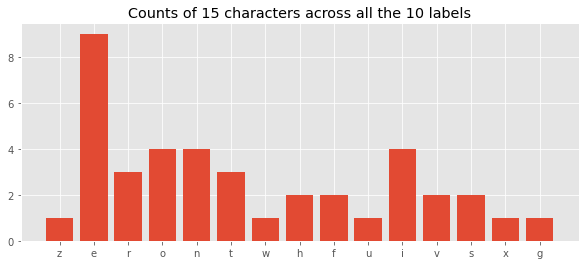

In [ ]:
# Create a pool of labels which our model is expected to output
label_pool = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

# Examine the distribution of letters in all these labels
chars = []
for l in label_pool:
    chars.extend(list(l))

char_counts = Counter(chars)
plt.figure(figsize = (10,4))
plt.bar(char_counts.keys(), char_counts.values());
plt.title(f"Counts of {len(char_counts)} characters across all the 10 labels");

**Observations**

From this we can think that
- In any batch which is picked using random sampling, there's a high chance that characters like `o`, `i`, `e` will appear in the word representation, so these character embeddings should get trained pretty well.
- Characters like `x`, `w`, `g` etc. might be underrepresented in our batches as opposed to the above characters. We could think of using weighted sampling for dataloading such that characters like x, g etc. also appear higher number of times.

**Build the text pipeline**

In [ ]:
# Load the embedding data which was extracted and stored
data = pickle.load(open("data/embeddings_with_labels.pkl", "rb"))

In [ ]:
# Create an output map which gives the output of the class in the form of alphabets
output_map = {0: "zero", 1:"one", 2:"two", 3:"three", 
              4: "four", 5: "five", 6: "six", 7:"seven",
              8: "eight", 9: "nine"}

In [ ]:
# Create a vocabulary of alphabets which are used in the word representation
# This is to basically help frame the problem using LSTM as a next alphabet prediction 
vocab = []
for item in output_map.values():
    vocab.extend(list(item))

# Add the special tokens to the vocabulary list
vocab.extend([START, STOP])
vocab = sorted(list(set(vocab)))

In [ ]:
# Recreate output_map in form of lists of alphabets in place of single string words
for k, v in output_map.items():
    v = [START] + list(v) + [STOP]
    output_map[k] = v

In [ ]:
# Create two sided mapping from word to index and vice-versa
idx_to_alphabet = {}
alphabet_to_idx = {}

ix = 1
for w in vocab:
    alphabet_to_idx[w] = ix
    idx_to_alphabet[ix] = w
    ix += 1
    
VOCAB_SIZE = len(idx_to_alphabet) + 1
VOCAB_SIZE

18

In [ ]:
# Display all the important data structures created above
print(f"VOCAB: \n{vocab}\n")
print(f"OUTPUT MAP: \n{output_map}\n")
print(f"IDX TO ALPHABET: \n{idx_to_alphabet}\n")
print(f"ALPHABET TO IDX: \n{alphabet_to_idx}")

VOCAB: 
['e', 'endseq', 'f', 'g', 'h', 'i', 'n', 'o', 'r', 's', 'startseq', 't', 'u', 'v', 'w', 'x', 'z']

OUTPUT MAP: 
{0: ['startseq', 'z', 'e', 'r', 'o', 'endseq'], 1: ['startseq', 'o', 'n', 'e', 'endseq'], 2: ['startseq', 't', 'w', 'o', 'endseq'], 3: ['startseq', 't', 'h', 'r', 'e', 'e', 'endseq'], 4: ['startseq', 'f', 'o', 'u', 'r', 'endseq'], 5: ['startseq', 'f', 'i', 'v', 'e', 'endseq'], 6: ['startseq', 's', 'i', 'x', 'endseq'], 7: ['startseq', 's', 'e', 'v', 'e', 'n', 'endseq'], 8: ['startseq', 'e', 'i', 'g', 'h', 't', 'endseq'], 9: ['startseq', 'n', 'i', 'n', 'e', 'endseq']}

IDX TO ALPHABET: 
{1: 'e', 2: 'endseq', 3: 'f', 4: 'g', 5: 'h', 6: 'i', 7: 'n', 8: 'o', 9: 'r', 10: 's', 11: 'startseq', 12: 't', 13: 'u', 14: 'v', 15: 'w', 16: 'x', 17: 'z'}

ALPHABET TO IDX: 
{'e': 1, 'endseq': 2, 'f': 3, 'g': 4, 'h': 5, 'i': 6, 'n': 7, 'o': 8, 'r': 9, 's': 10, 'startseq': 11, 't': 12, 'u': 13, 'v': 14, 'w': 15, 'x': 16, 'z': 17}


In [ ]:
# Find out the term with the maximum length; This is to help pad all the sequences to a same length
MAX_SEQUENCE_LENGTH = max([len(x) for x in output_map.values()])
print(f"The label/word with maximum length (including start and stop tokens) is {MAX_SEQUENCE_LENGTH}")

The label/word with maximum length (including start and stop tokens) is 7


In [ ]:
# Define train and test set inputs
train = data["train"]
train_embeds, train_labels = train["embeddings"], train["labels"]

test = data["test"]
test_embeds, test_labels = test["embeddings"], test["labels"]

In [ ]:
# Define a data generator
# We will not be able to load everything at once in memory
# Hence need to use a generator which yields the current batch and remembers
# the state of the last returned batch so it could resume from there onwards 
def data_generator(labels, image_embeds, alphabet_to_idx,
                   max_length = MAX_SEQUENCE_LENGTH, num_photos_per_batch = BATCH_SIZE):
    # x1 - Training data for photos/image embeddings
    # x2 - The word/alphabet that goes with each photo/embedding
    # y - The predicted rest of alphabets of the word
    x1, x2, y = [], [], []
    n = 0
    while True:
        for lbl, img_embed in zip(labels, image_embeds):
            n += 1
            
            # Find the label, convert it into a list of alphabet tokens
            val = output_map[lbl]
            seq = [alphabet_to_idx[alphabet] for alphabet in val if alphabet in alphabet_to_idx]
            
            # Generate a training case for every possible sequence and outcome
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen = max_length, padding = 'post')[0]
                out_seq = to_categorical([out_seq], num_classes = VOCAB_SIZE)[0]
                x1.append(img_embed)
                x2.append(in_seq)
                y.append(out_seq)
            
            # On collecting as many as num_of_photos_per_batch images, yield this as the output
            if n == num_photos_per_batch:
                out = ((np.array(x1), np.array(x2)), np.array(y))
                yield out
                x1, x2, y = [], [], []
                n = 0

In [ ]:
# Make a temporary generator to understand how the data is being curated
# Only show one sample here end to end
temp_gen = data_generator(train_labels, train_embeds, alphabet_to_idx, 
                          MAX_SEQUENCE_LENGTH, 1)

Input: ['img_embed', 'startseq']
Output: f

Input: ['img_embed', 'startseq', 'f']
Output: i

Input: ['img_embed', 'startseq', 'f', 'i']
Output: v

Input: ['img_embed', 'startseq', 'f', 'i', 'v']
Output: e

Input: ['img_embed', 'startseq', 'f', 'i', 'v', 'e']
Output: endseq



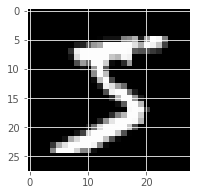

In [ ]:
# Extract one sample from the temporary generator created above
sample = next(temp_gen)
(img, seq), out = sample

# Show the image for which we are making the caption
plt.figure(figsize = (3, 3))
plt.imshow(X_train[0], cmap = "gray")

# Input the image embedding plus the individual tokens/alphabets one by one
# and then predict next token as the output, stop on encountering the end token
for s, o in zip(seq, out):
    print(f"Input: {['img_embed'] + [idx_to_alphabet[x] for x in s if x != 0]}\nOutput: {idx_to_alphabet[o.argmax()]}\n")

Input: ['img_embed', 'startseq']
Output: z

Input: ['img_embed', 'startseq', 'z']
Output: e

Input: ['img_embed', 'startseq', 'z', 'e']
Output: r

Input: ['img_embed', 'startseq', 'z', 'e', 'r']
Output: o

Input: ['img_embed', 'startseq', 'z', 'e', 'r', 'o']
Output: endseq



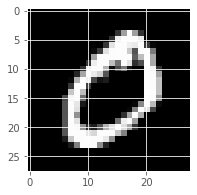

In [ ]:
# Extract another sample from the temporary generator created above
sample = next(temp_gen)
(img, seq), out = sample

# Show the image for which we are making the caption
plt.figure(figsize = (3, 3))
plt.imshow(X_train[1], cmap = "gray")

# Input the image embedding plus the individual tokens/alphabets one by one
# and then predict next token as the output, stop on encountering the end token
for s, o in zip(seq, out):
    print(f"Input: {['img_embed'] + [idx_to_alphabet[x] for x in s if x != 0]}\nOutput: {idx_to_alphabet[o.argmax()]}\n")

In [ ]:
# Create an embedding matrix, start with random embeddings
# Set the seed to a number to ensure reproducibility
np.random.seed(314)
embedding_matrix = np.random.randn(VOCAB_SIZE, TEXT_EMBED_DIMENSION)

# Model Building

In [ ]:
# Define the model architecture here

# Define the encoder architecture i.e. input of embedding
# obtained from resnet50 embedding as the input
inputs1 = Input(shape=(IMAGE_EMBED_DIMENSION, ))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(128, activation='relu')(fe1)

# Define the Decoder architecture
# i.e. LSTM with two layers and a dropout sandwiched between them
inputs2 = Input(shape=(MAX_SEQUENCE_LENGTH,))
se1 = Embedding(VOCAB_SIZE, TEXT_EMBED_DIMENSION, mask_zero=True)(inputs2)
se2 = LSTM(256, return_sequences = True)(se1)
se3 = Dropout(0.5)(se2)
se4 = LSTM(128)(se3)

# Add a dense head to do a classification in the final layer after LSTM
# Add batch normalization for faster training and also dropout to 
# have a good regularization effect
fc1 = add([fe2, se4])
bn1 = BatchNormalization()(fc1)
fc2 = Dense(128, activation='relu')(bn1)
decoder2 = Dropout(0.5)(fc2)
bn2 = BatchNormalization()(decoder2)
outputs = Dense(VOCAB_SIZE, activation='softmax')(bn2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
# Have a look at the model summary
caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7, 32)        576         ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 7, 256)       295936      ['embedding[0][0]']              
                                                                                              

# Model Compilation

- Classification problem i.e. next most likely alphabet is going to be the class that needs to be predicted based on the given input, hence using `Categorical Cross Entropy` as the loss function
- Optimizer used is Adam with a learning rate of 0.001; learning rate is the default one, we tried other lrs as well  but this one was giving a steeper decrease in loss (as opposed to rmsprop) so we chose this combination of lr and optimizer.

In [ ]:
# Set the weights of embeding layer to the ones we defined above
# Keep them trainable only since we're randomly initializing them and not loading them
# from any set of pretrained weights like glove/word2vec etx.
caption_model.layers[1].set_weights([embedding_matrix])
caption_model.compile(loss = 'categorical_crossentropy', 
                      optimizer = Adam(learning_rate = 1e-3))

In [ ]:
# Defining N and N_TEST will allow us to do experiments with small sets of data
# and then we can use the entire dataset for our experiments
N = len(train_labels) # 1000
N_TEST = len(test_labels) # 1000

train_gen = data_generator(train_labels[:N], train_embeds[:N], alphabet_to_idx, 
                           MAX_SEQUENCE_LENGTH, BATCH_SIZE)
test_gen = data_generator(test_labels[:N_TEST], test_embeds[:N_TEST], alphabet_to_idx, 
                          MAX_SEQUENCE_LENGTH, BATCH_SIZE)

Look at one batch of the training generator and tensor shapes and ascertain that they're indeed the correct shapes or not

In [ ]:
out = next(iter(train_gen))
(image_embeddings, text_seq), lbls = out[0], out[1]
image_embeddings.shape, text_seq.shape, lbls.shape

((157, 2048), (157, 7), (157, 18))

# Model Training

In [ ]:
# Take a modest batch size 
# Define how many batches are there in an epoch, this is for the generator to understand when an epoch is complete
# Take advantage of multiprocessing to load the data in memory
# Display the training logs and perform validation on a test set at the end of every epoch
import time
start = time.time()
BATCH_SIZE = 32
train_steps = N // BATCH_SIZE
test_steps = N_TEST // BATCH_SIZE
history_part_one = caption_model.fit(train_gen, 
                                     use_multiprocessing = True, 
                                     epochs = EPOCHS, 
                                     steps_per_epoch = train_steps,
                                     validation_data = test_gen,
                                     validation_steps = test_steps,
                                     verbose = 1)

Epoch 1/12
1875/1875 [==============================] - 124s 61ms/step - loss: 0.2775 - val_loss: 0.0673
Epoch 2/12
1875/1875 [==============================] - 112s 59ms/step - loss: 0.1047 - val_loss: 0.0579
Epoch 3/12
1875/1875 [==============================] - 111s 59ms/step - loss: 0.0918 - val_loss: 0.0545
Epoch 4/12
1875/1875 [==============================] - 103s 55ms/step - loss: 0.0848 - val_loss: 0.0500
Epoch 5/12
1875/1875 [==============================] - 103s 55ms/step - loss: 0.0804 - val_loss: 0.0500
Epoch 6/12
1875/1875 [==============================] - 103s 55ms/step - loss: 0.0763 - val_loss: 0.0493
Epoch 7/12
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0741 - val_loss: 0.0477
Epoch 8/12
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0712 - val_loss: 0.0474
Epoch 9/12
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0705 - val_loss: 0.0430
Epoch 10/12
1875/1875 [==============================] 

In [ ]:
# Reduce the learning rate after some epochs for stabilizing the learning
caption_model.optimizer.lr = 5e-4
history_part_two = caption_model.fit(train_gen, 
                                     use_multiprocessing = True, 
                                     epochs = EPOCHS, 
                                     steps_per_epoch = train_steps,
                                     validation_data = test_gen,
                                     validation_steps = test_steps,
                                     verbose = 1)

Epoch 1/12
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0614 - val_loss: 0.0400
Epoch 2/12
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0583 - val_loss: 0.0381
Epoch 3/12
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0585 - val_loss: 0.0378
Epoch 4/12
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0577 - val_loss: 0.0400
Epoch 5/12
1875/1875 [==============================] - 100s 54ms/step - loss: 0.0567 - val_loss: 0.0381
Epoch 6/12
1875/1875 [==============================] - 100s 54ms/step - loss: 0.0556 - val_loss: 0.0370
Epoch 7/12
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0555 - val_loss: 0.0374
Epoch 8/12
1875/1875 [==============================] - 100s 54ms/step - loss: 0.0546 - val_loss: 0.0379
Epoch 9/12
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0549 - val_loss: 0.0370
Epoch 10/12
1875/1875 [==============================] - 1

In [ ]:
# Reduce the learning rate even more and train for more epochs
caption_model.optimizer.lr = 1e-4
history_part_three = caption_model.fit(train_gen, 
                                     use_multiprocessing = True, 
                                     epochs = EPOCHS, 
                                     steps_per_epoch = train_steps,
                                     validation_data = test_gen,
                                     validation_steps = test_steps,
                                     verbose = 1)

Epoch 1/12
1875/1875 [==============================] - 100s 54ms/step - loss: 0.0513 - val_loss: 0.0347
Epoch 2/12
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0499 - val_loss: 0.0348
Epoch 3/12
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0493 - val_loss: 0.0346
Epoch 4/12
1875/1875 [==============================] - 100s 54ms/step - loss: 0.0488 - val_loss: 0.0341
Epoch 5/12
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0481 - val_loss: 0.0341
Epoch 6/12
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0485 - val_loss: 0.0342
Epoch 7/12
1875/1875 [==============================] - 103s 55ms/step - loss: 0.0489 - val_loss: 0.0340
Epoch 8/12
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0490 - val_loss: 0.0340
Epoch 9/12
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0483 - val_loss: 0.0338
Epoch 10/12
1875/1875 [==============================] 

In [ ]:
train_time = time.time() - start
print(f"Training time: {train_time:.3f} seconds")

Training time: 3590.069 seconds


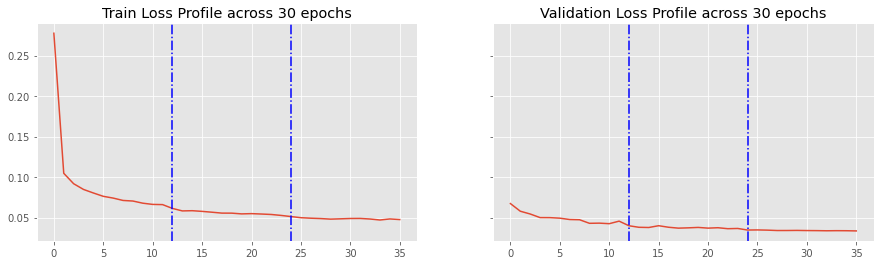

In [ ]:
# Plot the loss curves

# Train loss
train_loss = history_part_one.history["loss"] + history_part_two.history["loss"] + history_part_three.history["loss"]
train_minibatch_index = range(len(train_loss))
tr_break1 = len(train_loss) // 3; tr_break2 = 2 * len(train_loss) // 3

# Valid loss
valid_loss = history_part_one.history["val_loss"] + history_part_two.history["val_loss"] + history_part_three.history["val_loss"]
valid_minibatch_index = range(len(valid_loss))
vl_break1 = len(valid_loss) // 3; vl_break2 = 2 * len(valid_loss) // 3

fig, ax = plt.subplots(1, 2, figsize = (15,4), sharey = True)
# Plot train loss and validation loss with different colors
ax[0].plot(train_minibatch_index, train_loss)#, color = "r")
ax[1].plot(valid_minibatch_index, valid_loss)#, color = "b")

ax[0].axvline(tr_break1, linestyle = "dashdot", color = "b")
ax[0].axvline(tr_break2, linestyle = "dashdot", color = "b")

ax[1].axvline(vl_break1, linestyle = "dashdot", color = "b")
ax[1].axvline(vl_break2, linestyle = "dashdot", color = "b")

ax[0].set_title("Train Loss Profile across 30 epochs")
ax[1].set_title("Validation Loss Profile across 30 epochs");

In [ ]:
# Save the training stats
# pickle.dump({"train_loss": train_loss, "valid_loss": valid_loss, "epoch": EPOCHS}, open("data/loss_profile.pkl", "wb"))

In [ ]:
# Save the model to disk
caption_model.save_weights("models/alphabet_caption_generation_15_epochs_with_bn.h5")

In [ ]:
# caption_model.load_weights("models/alphabet_caption_generation.h5")

# Model Evaluation

I have curated a test set by using a GAN model obtained from kaggle which generates MNIST images and a few more by manually drawing on a black canvas, they're as follows. Let's evaluate on this test set!

<img src="https://i.imgur.com/e9FWTaZ.png">

In [ ]:
# from pathlib import Path
# for sample in Path("samples/").glob("*"):
#     if sample.is_file():
#         PIL.Image.open(sample).convert("L").resize((28,28)).save(sample)

In [ ]:
# Define a function to get the encoded representation for the image
def get_encoder():
    new_input = Input(shape=(28, 28, 3))
    res = ResNet50(include_top=False, input_tensor=new_input)
    return res

# Get the embedding using encoder defined above
def get_embedding(img_pth, encoder):
    img = np.array(PIL.Image.open(img_pth).convert("RGB"))
    image = img.reshape((1, *img.shape))
    return encoder.predict(image, verbose = 0)[0][0]

In [ ]:
# Given the image embedding, define a function to generate the caption for 
def generateCaption(img_embed):
    
    # Start with the image embedding and the startseq tag
    in_text = START
    
    # Loop over for as much length as the max sequence length
    for i in range(MAX_SEQUENCE_LENGTH):
        
        # Start with only the start seq and iteratively feed subsequent alphabets/tokens into the in_text word 
        sequence = [alphabet_to_idx[w] for w in in_text.split() if w in alphabet_to_idx]
        sequence = pad_sequences([sequence], maxlen = MAX_SEQUENCE_LENGTH, padding = "post")
        
        # Give the image embedding and sequence and predict the next alphabet/token
        yhat = caption_model.predict([img_embed, sequence], verbose=0)
        yhat = np.argmax(yhat)
        alphabet = idx_to_alphabet[yhat]
        in_text += ' ' + alphabet
        
        # If we reach the end of sequence, stop the generation
        if alphabet == STOP:
            break
    
    # Remove the start and stop tokens and then give the output
    final = in_text.split()
    if final[-1] == STOP: final = final[1:-1]
    else: final = final[1:]
    
    # Join the tokens with space separation to point the individual tokens apart
    final = ' '.join(final)
    return final

In [ ]:
# Get the encoder
encoder = get_encoder()

# Get a list of unseen samples which we have generated using a GAN and handwritten images
# To check the generalization performance
unseen_samples = sorted(list(Path("samples").glob("*")), key = lambda x: x.stem)
unseen_map = {}

# Make a map of the generated caption against the input sample's name
for sample in tqdm(unseen_samples, total = len(unseen_samples)):
    if (sample.is_file()) and (not sample.parent.name.startswith(".")):
        embed = get_embedding(sample, encoder)
        caption = generateCaption(embed)
        unseen_map[sample.name] = caption

100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


In [ ]:
# Segregate GAN and hand written number images apart
GAN_imgs = [x for x in unseen_map.keys() if x.startswith("GAN")]
hand_imgs = [x for x in unseen_map.keys() if x.startswith("hand")]

**BLEU Score computation**

Instead of using accuracy or f1-score or any other classification metrics, for text generation, `BLEU Score` is a more commonly used metric. Hence using this instead for model evaluation.

Also, in CANVAS, Seetha ma'am had approved the use of this metric over others for evaluation; hence using this metric.

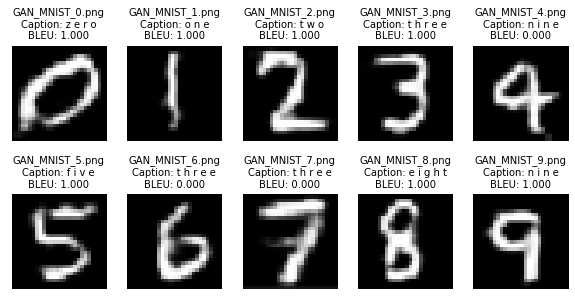

In [ ]:
# Show the GAN output
fig, ax = plt.subplots(2, 5, figsize = (10,5))
for name, a in zip(GAN_imgs, ax.flat):
    prediction = unseen_map[name]
    a.imshow(PIL.Image.open(f"samples/{name}"), cmap = "gray")
    a.set_xticks([]); a.set_yticks([]);
    
    # Compute BLEU Score    
    temp = name.split(".")[0].split("_")[-1]
    ground_truth = output_map[int(temp)]
    reference_chars = max(len(ground_truth) - 2, len(prediction.split()))
    weights = [1/reference_chars] * reference_chars
    score = sentence_bleu([ground_truth[1:-1]] ,prediction.split(" "), weights = weights)
    
    # Display the score along with the image name and caption/prediction  
    a.set_title(f"{name}\nCaption: {prediction}\nBLEU: {score:.3f}", fontsize = 10)

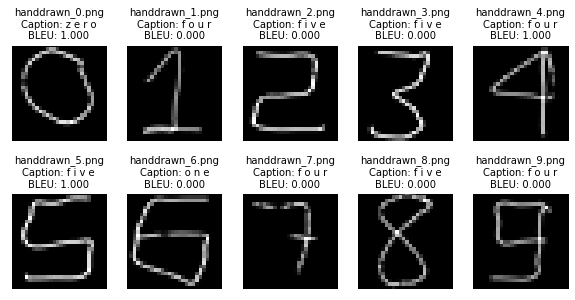

In [ ]:
# Show the handwritten output
fig, ax = plt.subplots(2, 5, figsize = (10,5))
for name, a in zip(hand_imgs, ax.flat):
    prediction = unseen_map[name]
    a.imshow(PIL.Image.open(f"samples/{name}"), cmap = "gray")
    a.set_xticks([]); a.set_yticks([]);
    
    # Compute BLEU Score    
    temp = name.split(".")[0].split("_")[-1]
    ground_truth = output_map[int(temp)]
    reference_chars = max(len(ground_truth) - 2, len(prediction.split()))
    weights = [1/reference_chars] * reference_chars
    score = sentence_bleu([ground_truth[1:-1]] ,prediction.split(" "), weights = weights)
    
    # Display the score along with the image name and caption/prediction  
    a.set_title(f"{name}\nCaption: {prediction}\nBLEU: {score:.3f}", fontsize = 10)

# Conclusion

We built a model that embeds images in a latent space, and subsequently accepts tokens and builds upon the same using an LSTM to get a word from the image.

We saw that the resulting model works well on images in the same distribution however it doesn't perform so well on out of distribution images i.e. handdrawn images with a thin pen of slightly different font. This means our model is very sensitive and we need to show our model more examples of the same to make it work well on different distribution data

# References
1. [Generation of MNIST Images GAN](https://www.kaggle.com/code/zhoulingyan0228/generating-mnist-gan)
2. [Image captioning by Jeff Heaton](https://www.youtube.com/watch?v=NmoW_AYWkb4)
3. [Github notebook for image captioning](https://github.com/jeffheaton/t81_558_deep_learning/blob/8466852fb7f85bc816dbd08102c10209d4719b16/t81_558_class_10_4_captioning.ipynb)